In [2]:
# MIT License

# Copyright (c) 2017 Johannes Dollinger

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# https://github.com/emulbreh/bridson

from random import random
from math import cos, sin, floor, sqrt, pi, ceil

def euclidean_distance(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return sqrt(dx * dx + dy * dy)

def poisson_disc_samples(width, height, r, k=5, distance=euclidean_distance, random=random):
    tau = 2 * pi
    cellsize = r / sqrt(2)

    grid_width = int(ceil(width / cellsize))
    grid_height = int(ceil(height / cellsize))
    grid = [None] * (grid_width * grid_height)

    def grid_coords(p):
        return int(floor(p[0] / cellsize)), int(floor(p[1] / cellsize))

    def fits(p, gx, gy):
        yrange = list(range(max(gy - 2, 0), min(gy + 3, grid_height)))
        for x in range(max(gx - 2, 0), min(gx + 3, grid_width)):
            for y in yrange:
                g = grid[x + y * grid_width]
                if g is None:
                    continue
                if distance(p, g) <= r:
                    return False
        return True

    p = width * random(), height * random()
    queue = [p]
    grid_x, grid_y = grid_coords(p)
    grid[grid_x + grid_y * grid_width] = p

    while queue:
        qi = int(random() * len(queue))
        qx, qy = queue[qi]
        queue[qi] = queue[-1]
        queue.pop()
        for _ in range(k):
            alpha = tau * random()
            d = r * sqrt(3 * random() + 1)
            px = qx + d * cos(alpha)
            py = qy + d * sin(alpha)
            if not (0 <= px < width and 0 <= py < height):
                continue
            p = (px, py)
            grid_x, grid_y = grid_coords(p)
            if not fits(p, grid_x, grid_y):
                continue
            queue.append(p)
            grid[grid_x + grid_y * grid_width] = p
    return [p for p in grid if p is not None]

poisson_disc_samples(10, 10, 2, k=5)

[(2.6015669996617388, 0.08838141763692908),
 (4.37513854841511, 1.3796594856745719),
 (0.8762962274037895, 2.2837630318644044),
 (9.606567766522577, 1.7799003698348197),
 (2.9411808208730963, 4.031031491769144),
 (5.907836465294097, 3.068932325327588),
 (7.743795950425179, 4.051541040671721),
 (0.3151446313480393, 6.656464726530496),
 (7.770058742950863, 6.207491151267984),
 (9.911335506071744, 6.060426707050278),
 (2.7270067279684773, 8.170287138744355),
 (5.286385870514669, 7.106770245530788),
 (8.038864879755101, 8.346459826604644),
 (1.0023948646957226, 9.801039565533117),
 (9.768898404146512, 9.77590940873232),
 (4.566046457957872, 9.913969680622476)]

In [3]:
import random

from geopy.distance import geodesic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.weight': 'bold'})

In [4]:
import random
import kdtree
from math import cos, sin, floor, sqrt, pi, ceil

debug = False

def saveNedFile(fileName, networkName, nodeMap, mapHeightM):
    template = open("nedGenTemplate.txt", "r")
    templateTxt = template.read()
    templateTxt = templateTxt.replace('##{NETWORK_NAME}##', networkName)
    templateTxt = templateTxt.replace('##{BGB}##', str(mapHeightM) + ',' + str(mapHeightM))
    
    df = pd.DataFrame(data=reversed(nodeMap))
    maximum_x_value = df['x'].max()
    minimum_x_value = df['x'].min()
    maximum_y_value = df['y'].max()
    minimum_y_value = df['y'].min()
    
    scale = 1
    
    nodesStr = ''
    i = 1
    for node in nodeMap:
        mode = 'lpn'

        
        #sensors[numSensors]: MobileSensorNode {
        #    @display("i=misc/sensor");
        #}
        if(node['mode'] == 'relay'):
            mode = 'fn_rly'
        nodeText = '\n    sensors_' + str(i) + ': MobileSensorNode {'
        nodeText = nodeText + '\n        @display("i=misc/sensor,p=' + "{:.2f}".format((node['x'])*scale) + ',' + "{:.2f}".format((mapHeightM - node['y'])*scale) + '");'
        nodeText = nodeText + '\n    }\n'
        nodesStr = nodesStr + nodeText
        i = i + 1
    
    templateTxt = templateTxt.replace('##{NODES}##', nodesStr)
    
    f = open(fileName, "w")
    f.write(templateTxt)
    f.close()

def toRadians(degrees):
    return degrees * pi / 180

def toDegrees(radians):
    return radians * 180 / pi

def saveIniFile(networkNames, nodeMaps):
    template = open("iniGenTemplate.txt", "r")
    templateTxt = template.read()
    
    output = open("dadcaAckSim.ini", "w")
    
    fileContent = ''
    
    for networkName in networkNames:
        templateTxtTemp = templateTxt
        templateTxtTemp = templateTxtTemp.replace('##{NETWORK_NAME}##', networkName)

        nodeMap = nodeMaps[networkName]
        nodePositionsIniStr = ''
        sensorI = 1
        
        iniLat = -15.8401
        iniLon = -47.9266
    
        for node in nodeMap:
            
            # Translate from iniLat,iniLon to a new latitude adding the (x,y) points.
            #origin = (iniLat, iniLon)
            #destination = geodesic(kilometers=(node['y'] / 1000), bearing=0).destination(origin, node['x'] / 1000)
            #lat = destination.latitude
            #lon = destination.longitude
            
                        
            #lat = toRadians(iniLat) + node['y'] / (40007000.0 / (2.0 * pi))
            #lon = toRadians(iniLon) + node['x'] / ((40075000.0 / (2.0 * pi)) * cos(toRadians(iniLat)))

            #lat = toDegrees(lat)
            #lon = toDegrees(lon)
            
            lat = iniLat + node['y'] / (40007000.0 / (2.0 * pi))
            lon = iniLon + node['x'] / ((40075000.0 / (2.0 * pi)) * cos(iniLat))

            # https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
                        
            #Earth’s radius, sphere
            R=6378137
            
            #offsets in meters
            dn = node['y']
            de = node['x']
            
            #Coordinate offsets in radians
            dLat = dn/R
            dLon = de/(R*cos(pi*iniLat/180))
            
            #OffsetPosition, decimal degrees
            #lat = iniLat + dLat * 180/pi
            #lon = iniLon + dLon * 180/pi 

            #lat_degrees_per_meter = 1 / 111320.0
            #lon_degrees_per_meter = 1 / (40075000.0 / 360.0)

            #lat = iniLat + (node['y'] * lat_degrees_per_meter)
            #lon = iniLon + (node['x'] * lon_degrees_per_meter)

            nodePositionsIniStr += '*.sensors_' + str(sensorI) + '.mobility.initialLatitude = %.8fdeg\n'%lat
            nodePositionsIniStr += '*.sensors_' + str(sensorI) + '.mobility.initialLongitude = %.8fdeg\n'%lon
            sensorI = sensorI + 1

        # Add node positions
        templateTxtTemp = templateTxtTemp.replace('##{S1-END}##', nodePositionsIniStr)
        templateTxtTemp = templateTxtTemp.replace('##{S2-END}##', nodePositionsIniStr)
        
        fileContent = fileContent + templateTxtTemp
    
    appendedIni = open("omnetpp.ini", "r")
    fileContent = fileContent + appendedIni.read()
    appendedIni.close()
    
    output.write(fileContent)
    output.close()
    
def getRandomPoint(mapWidthM, mapHeightM, startX, startY, minDistance, maxDistance):
    x = -1
    y = -1
    
    while x < 0 or y < 0 or x > mapWidthM or y > mapHeightM:
        targetDistance = random.uniform(minDistanceM,maxDistanceM)
        theta = random.random()*pi*2
        
        x = startX + cos(theta)*targetDistance;
        y = startY + sin(theta)*targetDistance;
    return [x,y]

def dist2(p1,p2):
    return sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

# This class emulates a tuple, but contains a useful payload
class Item(object):
    def __init__(self, x, y, data):
        self.coords = (x, y)
        self.data = data

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, i):
        return self.coords[i]

    def __repr__(self):
        return 'Item({}, {}, {})'.format(self.coords[0], self.coords[1], self.data)

def genMap(mapWidthM, mapHeightM, nodeCount, lpnFnRatio, minDistanceM, maxDistanceM):
    
    nRelayNodes = ceil(nodeCount/lpnFnRatio)

    if nRelayNodes <= 0:
        print('Invalid nodeCount/lpnFnRatio proportion')
        exit

    print(str(nodeCount) + ' nodes. ' + str(lpnFnRatio) + ' LPN per FN. FN/RN (ceiled) count = ' + str(nRelayNodes))

    startX = 100 # Always enforcing a relay node within collector range #random.randint(0, mapWidthM)
    startY = mapHeightM - 100 # (collector #1 starts at 100,100) #random.randint(0, mapHeightM)

    nodeMap = [{
        'x': startX,
        'y': startY,
        'mode': 'relay'
    }]
    
    mapDistances = kdtree.create([Item(float(startX), float(startY), [startX, startY])], dimensions=2) # https://github.com/stefankoegl/kdtree

    for i in range(1, nodeCount):
        lpn = i >= nRelayNodes

        while True:
            mode = None
            x = None
            y = None

            if not lpn:
                mode = 'relay'
                # Relay node. Should spawn near the last appended relay node
                randomPoint = getRandomPoint(mapWidthM, mapHeightM, startX, startY, minDistanceM, maxDistanceM)
                x = randomPoint[0]
                y = randomPoint[1]
                startX = x
                startY = y
            else:
                mode = 'lpn'
                relayIdx = int((i - nRelayNodes) % nRelayNodes)

                relay = nodeMap[relayIdx]
                if relay['mode'] != 'relay':
                    print('Error. LPN chose a non-relay node to spawn near-to')
                    exit()

                # Low power node. Should spawn near a relay node.
                randomPoint = getRandomPoint(mapWidthM, mapHeightM, relay['x'], relay['y'], minDistanceM, maxDistanceM)
                x = randomPoint[0]
                y = randomPoint[1]
                        
            distanceToNearestNode2 = float('inf')
            
            if debug:
                for j in range(0, len(nodeMap)):
                    distanceToNearestNode2 = min(distanceToNearestNode2, sqrt( (x - nodeMap[j]['x'])**2 + (y - nodeMap[j]['y'])**2 ))
            
            nearestNodeSearchResult = mapDistances.search_nn(Item(float(x),float(y),[x,y]))
            distanceToNearestNode = dist2(nearestNodeSearchResult[0].data, [x,y])
            
            if distanceToNearestNode < minDistanceM:
                
                if debug:
                    print('dNN<min:' + str(distanceToNearestNode) + '<' + str(minDistanceM))
                    #kdtree.visualize(tree)
                    
                continue
            else:
                mapDistances.add(Item(float(x),float(y), [x,y]))
                                
                if distanceToNearestNode2 < minDistanceM:
                    print('[DEBUG] Adding node with d=' + str(distanceToNearestNode2) + '-kdtree=' + str(distanceToNearestNode))
                
                nodeMap.append({
                    'x': x,
                    'y': y,
                    'mode': mode
                })
                break
            
    return nodeMap

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


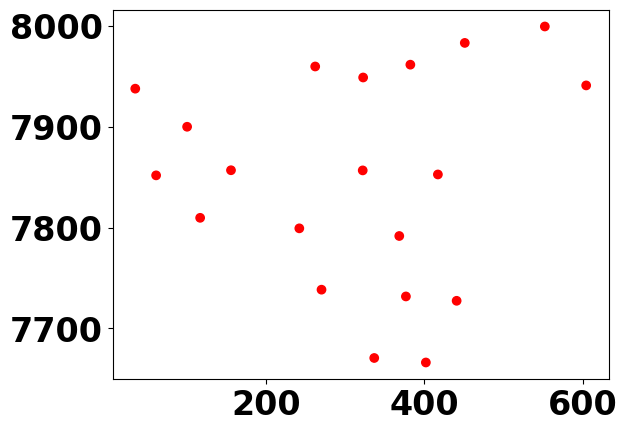

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


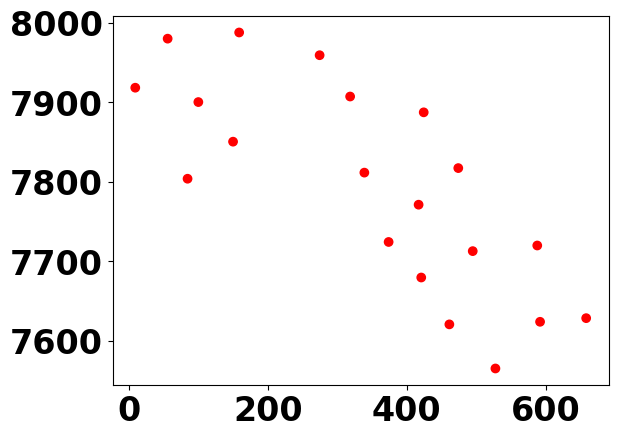

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


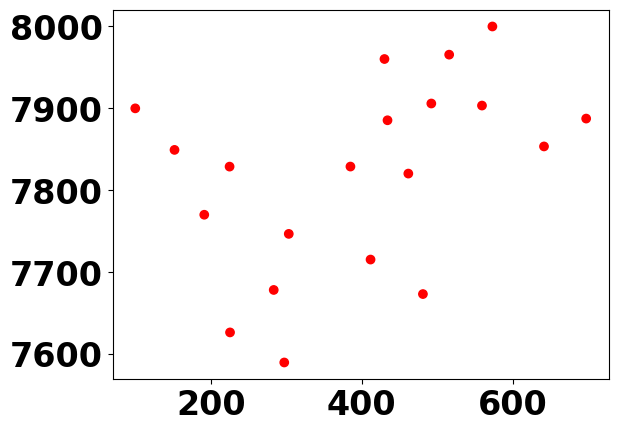

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


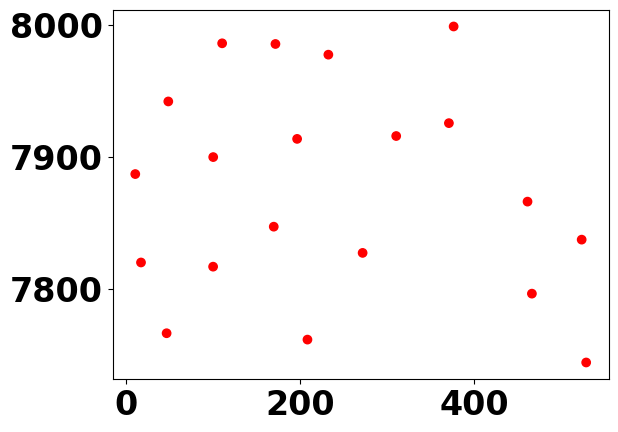

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


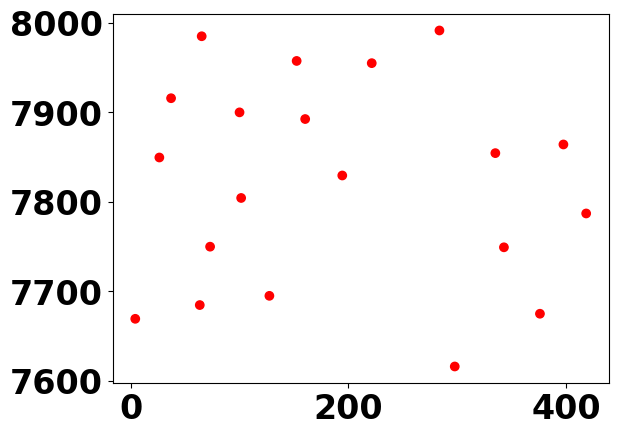

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


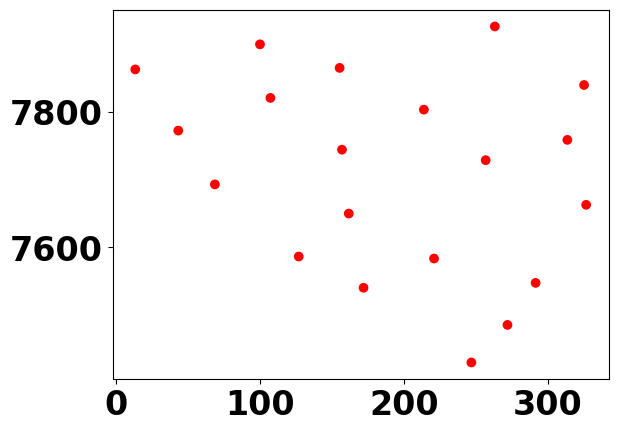

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


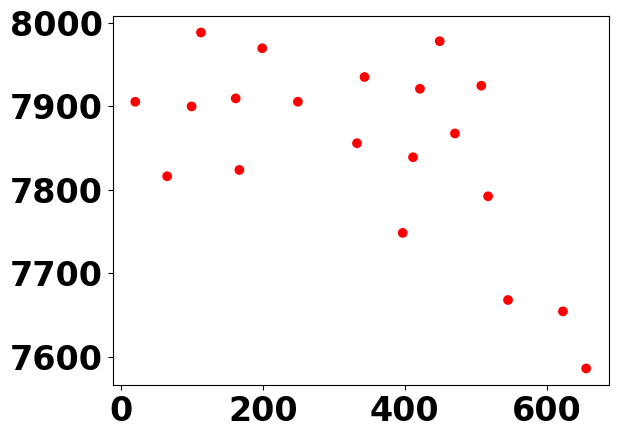

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


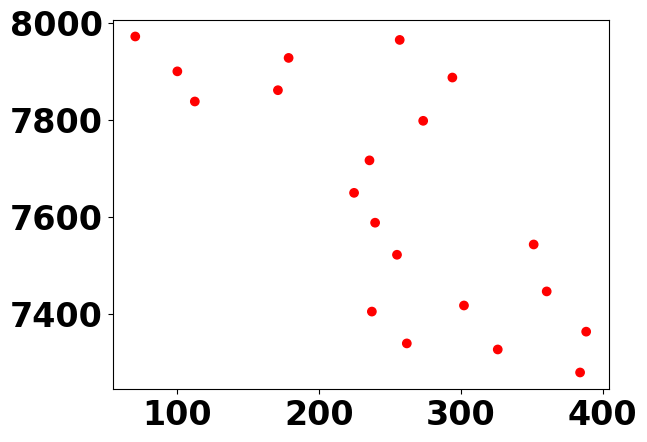

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


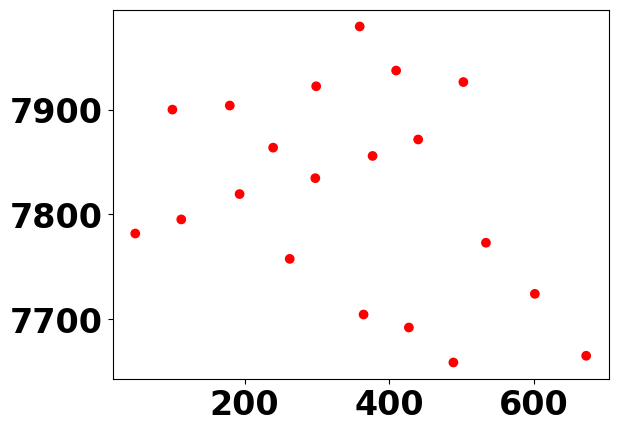

20 nodes. 1 LPN per FN. FN/RN (ceiled) count = 20


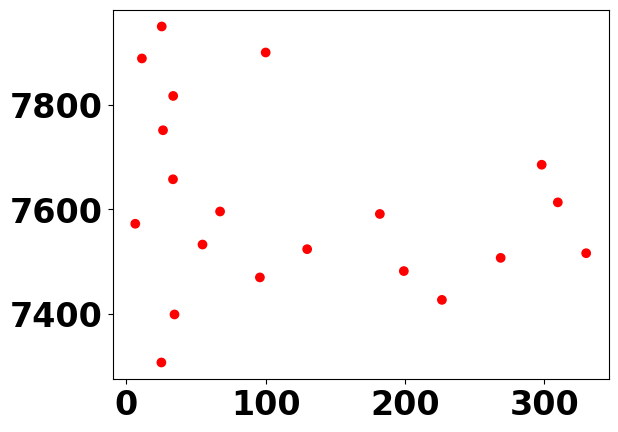

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


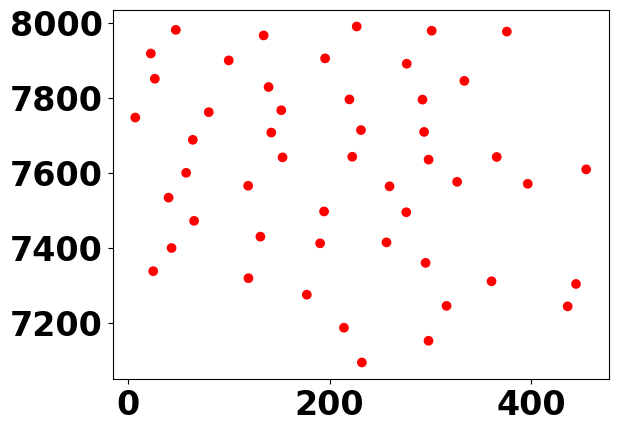

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


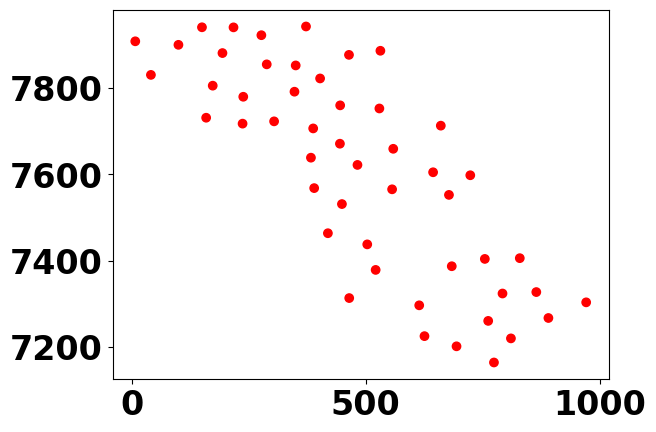

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


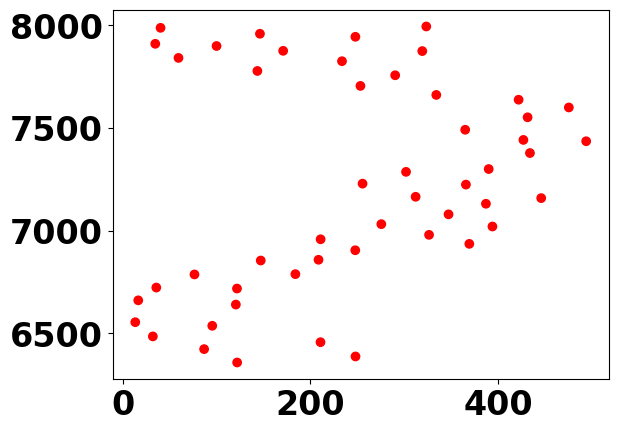

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


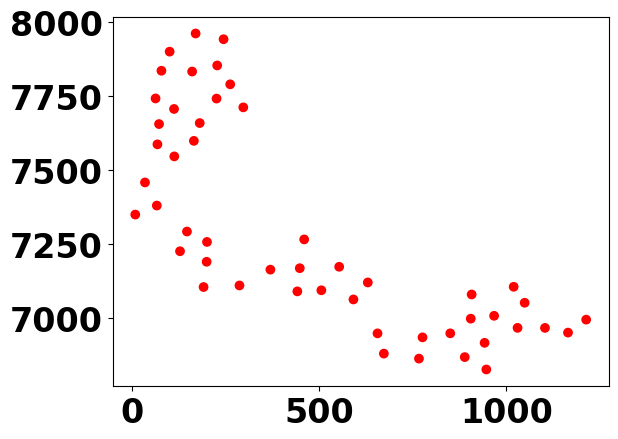

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


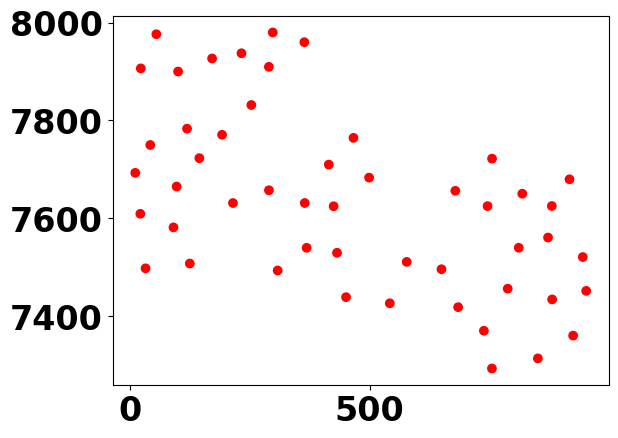

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


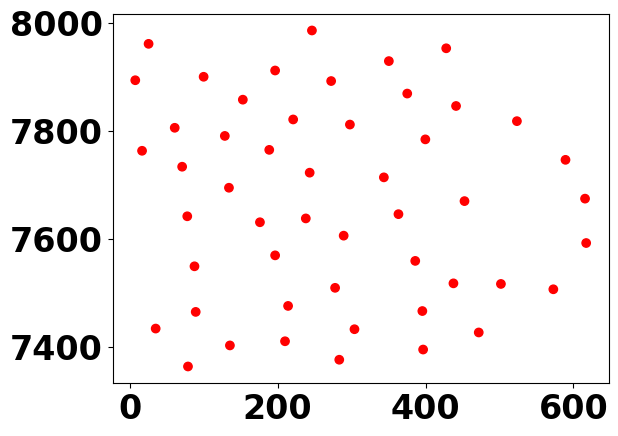

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


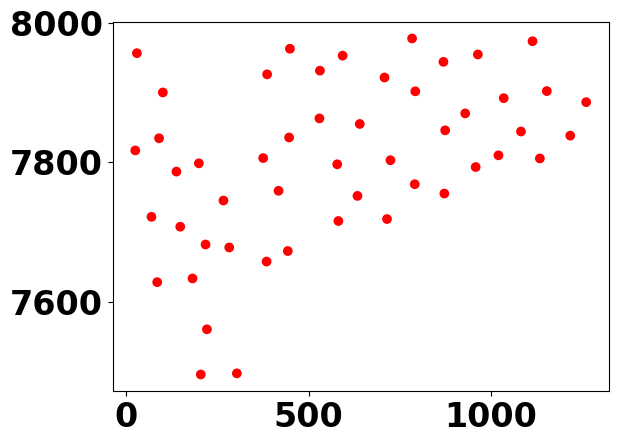

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


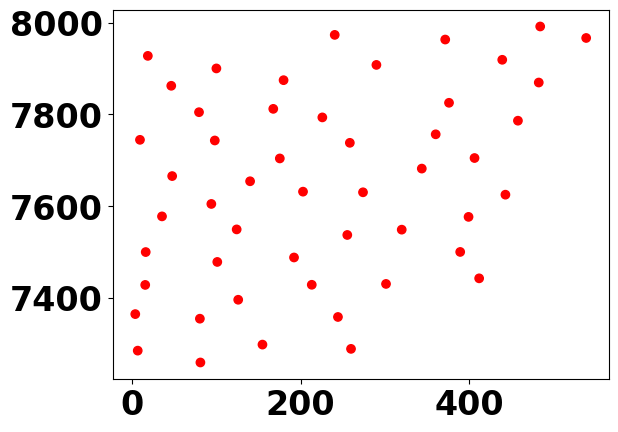

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


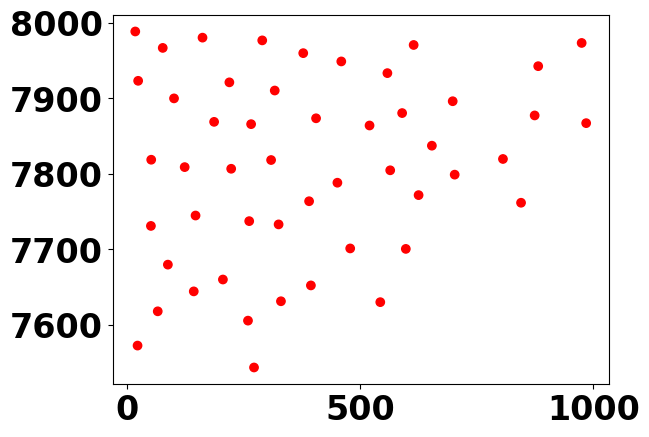

50 nodes. 1 LPN per FN. FN/RN (ceiled) count = 50


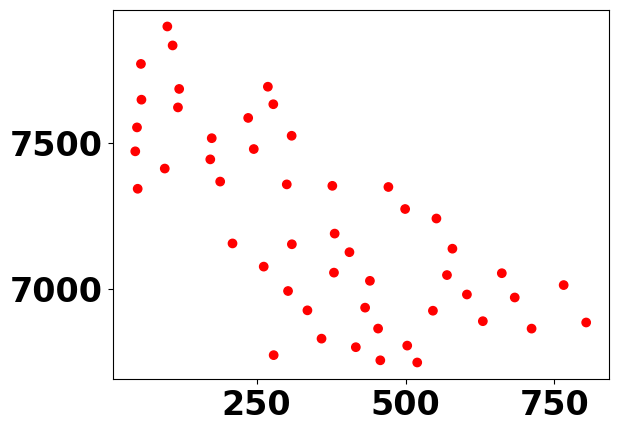

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


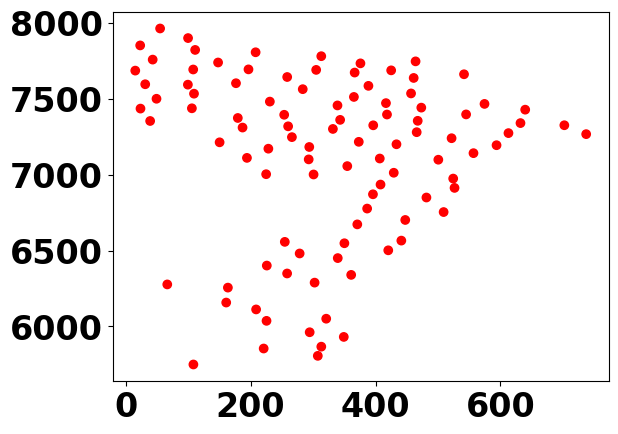

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


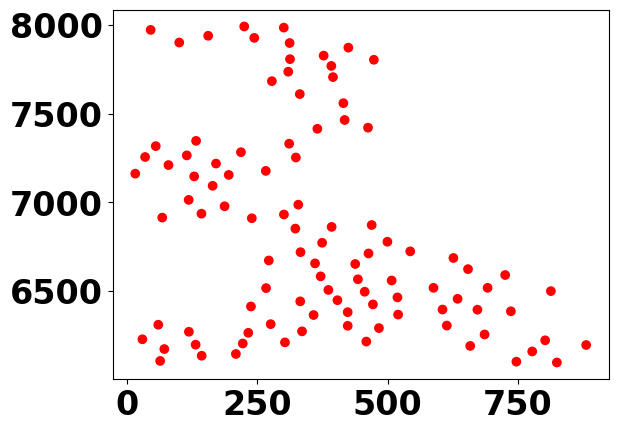

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


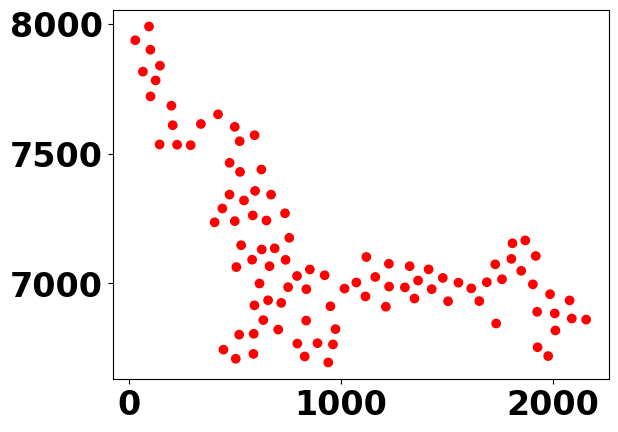

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


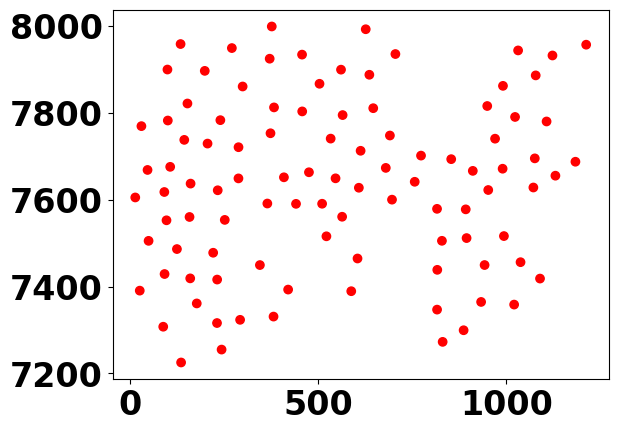

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


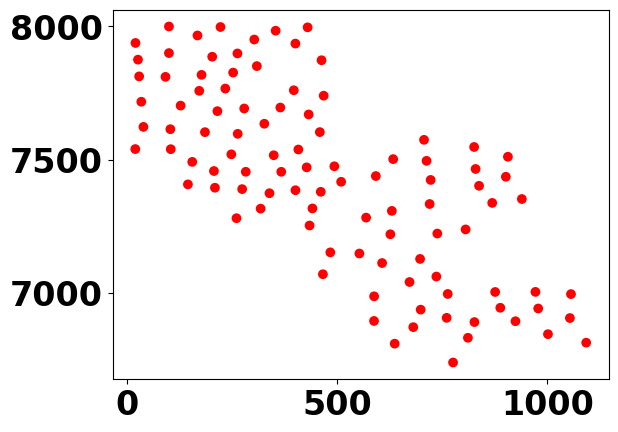

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


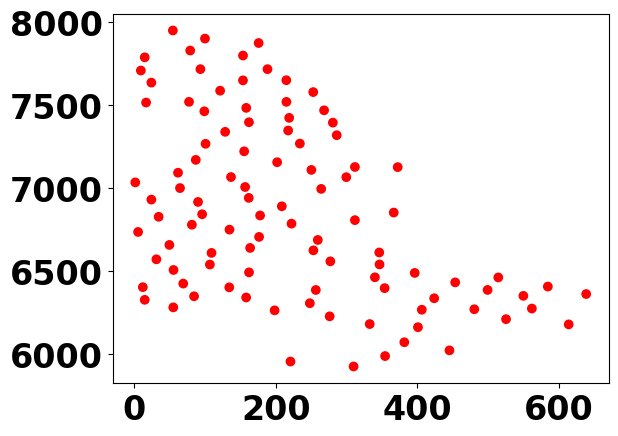

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


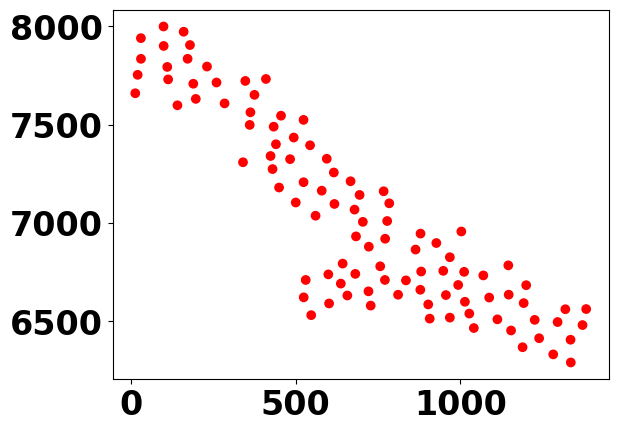

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


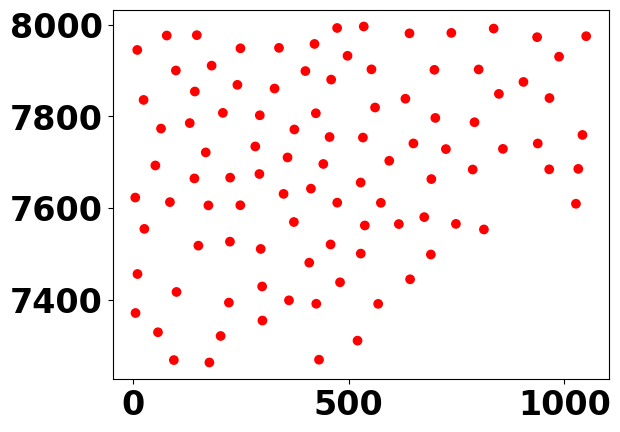

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


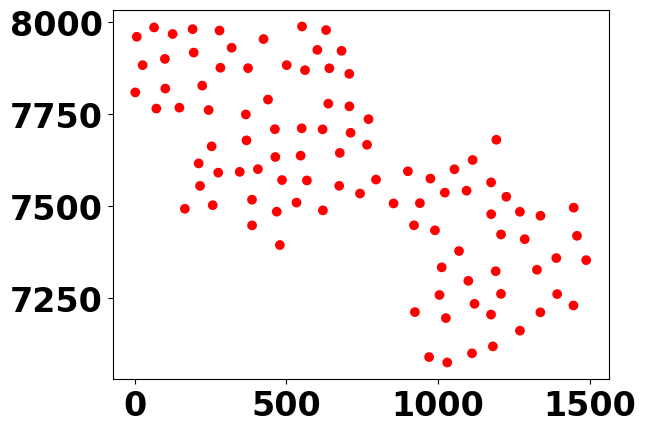

100 nodes. 1 LPN per FN. FN/RN (ceiled) count = 100


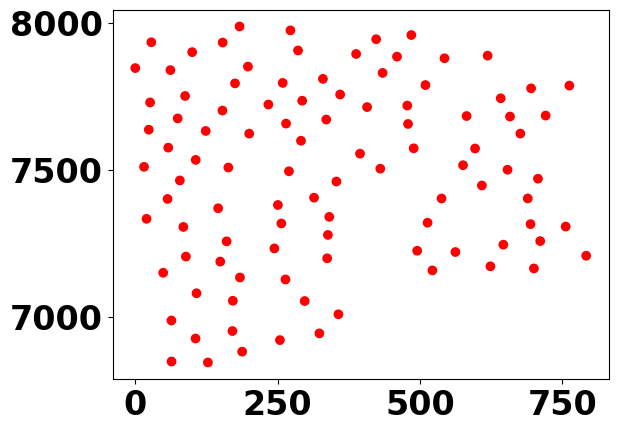

In [5]:
mapAreas = [8000]

nodeCounts = [20,50,100]

lpnFnRatios = [1]
minDistanceM = 60
maxDistanceM = 100

genTimes = 10

def runGen():
    networkMapNames = []
    nodeMaps = {}
    
    for mapArea in mapAreas:
        mapWidthM = mapArea
        mapHeightM = mapArea
    
        for nodeCount in nodeCounts:
            
            for lpnFnRatio in lpnFnRatios:

                for i in range (0, genTimes):
                    nodeMap = genMap(mapWidthM, mapHeightM, nodeCount, lpnFnRatio, minDistanceM, maxDistanceM)

                    if debug:
                        for i in range(0, len(nodeMap)):
                            for j in range(0, len(nodeMap)):
                                if i == j:
                                    continue
                                dist = sqrt( (nodeMap[i]['x'] - nodeMap[j]['x'])**2 + (nodeMap[i]['y'] - nodeMap[j]['y'])**2 )
                                if dist < minDistanceM:
                                    print('ERROR - dist=' + str(dist))


                    networkMapName = 'DADCA_ACK_n' + str(nodeCount) + '_' + 'a' + str(mapArea) + 'm2' + '_lpnFn' + str(lpnFnRatio) + '_' + str(i)
                    networkMapNames.append(networkMapName)
                    nodeMaps[networkMapName] = nodeMap
                    saveNedFile(networkMapName + '.ned', networkMapName, nodeMap, mapHeightM)
                    df = pd.DataFrame(data=reversed(nodeMap))
                    colors = {'relay':'red', 'lpn':'blue'}

                    plt.scatter(df['x'], df['y'], c=df['mode'].map(colors))
                    plt.show()
    
    saveIniFile(networkMapNames, nodeMaps)
    
runGen()